In [1]:
import os

local_path = os.getcwd()
# 设置工作目录为项目的主目录
os.chdir("../../")  # 使用相对路径将工作目录切换到 project 文件夹
print("Current working directory:", os.getcwd())

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from models import modelset
from train.train import train_FBM
from utils import *

Current working directory: /home/yixiong_ren/work/FBM


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
set_seed(42)

Using device: cuda


# 生成数据

两类数据为在高维空间中球形分布的GAUSS数据。如果两个球存在交叠，处于交叠区域的数据将会被标记为第三类。

In [3]:
import torch

def generate_sphere_data_with_overlap(
    num_samples_per_class, dimensions, radius_0, radius_1, center_0, center_1
):
    """
    生成两个类别的数据集，每类数据分布在一个高维球体内，并指定球心位置。
    如果生成的点同时属于两类（即满足两个球体的半径约束），则将其标记为标签 2。
    
    :param num_samples_per_class: 每个类别的样本数量
    :param dimensions: 高维空间的维数
    :param radius_0: 类别 0 球体的半径
    :param radius_1: 类别 1 球体的半径
    :param center_0: 类别 0 球体的球心位置 (list or tensor)
    :param center_1: 类别 1 球体的球心位置 (list or tensor)
    :return: 数据集 (features, labels)
    """
    def generate_points(num_samples, dimensions, radius_0, radius_1, center_0, center_1, add_label=1):
        data = []
        labels = []
        center_tensor_0 = torch.tensor(center_0, dtype=torch.float32)
        center_tensor_1 = torch.tensor(center_1, dtype=torch.float32)
        
        while len(data) < num_samples:
            # 从标准高斯分布生成点
            point = torch.randn(dimensions) + center_tensor_0
            
            # 计算点到两个球心的距离
            distance_to_0 = torch.norm(point - center_tensor_0)
            distance_to_1 = torch.norm(point - center_tensor_1)
            
            # 检查点是否在类别 0 和类别 1 的球体内
            in_sphere_0 = distance_to_0 <= radius_0
            in_sphere_1 = distance_to_1 <= radius_1
            
            if in_sphere_0 and in_sphere_1:
                # 如果点同时属于两类，标记为 2
                data.append(point)
                labels.append(2)
            elif in_sphere_0:
                # 如果点仅属于类别 0
                data.append(point)
                labels.append(add_label)


        return torch.stack(data), torch.tensor(labels, dtype=torch.long)
    
    # 生成数据和标签
    features1, labels1 = generate_points(
        num_samples_per_class,  # 生成更多点以处理两类重叠的情况
        dimensions,
        radius_0,
        radius_1,
        center_0,
        center_1,
        add_label = 0
    )
    features2, labels2 = generate_points(
        num_samples_per_class,  # 生成更多点以处理两类重叠的情况
        dimensions,
        radius_1,
        radius_0,
        center_1,
        center_0,
        add_label = 1
    )
    features, labels = torch.cat((features1, features2), dim=0), torch.cat((labels1, labels2), dim=0)

    return features, labels



# 可视化
通过PCA（TSNE）的方式将数据降为成2维度数据画图

In [4]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 可视化函数：将数据降维到 2D 并可视化
def visualize_2d(features, labels):
    """
    使用 t-SNE 将高维数据降维到 2D 并可视化。
    :param features: 高维特征数据 (tensor or numpy array)
    :param labels: 标签 (tensor or numpy array)
    """
    # 转换为 numpy
    features_np = features.detach().numpy()
    labels_np = labels.numpy()

    # 使用 t-SNE 降维到 2D
    _, dims =features.shape
    
    if dims > 2:
        #tsne = TSNE(n_components=2, random_state=42, perplexity=40)
        pca = PCA(n_components=2)
        features_2d = pca.fit_transform(features_np)
    else:
        features_2d = features_np

    # 绘制 2D 散点图
    plt.figure(figsize=(8, 6))
    for label in [0, 1, 2]:
        mask = labels_np == label
        plt.scatter(
            features_2d[mask, 0],
            features_2d[mask, 1],
            label=f"Class {label}",
            alpha=0.6
        )
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.title("Visualization of High-Dimensional Data")
    plt.legend()
    plt.grid(True)
    plt.show()

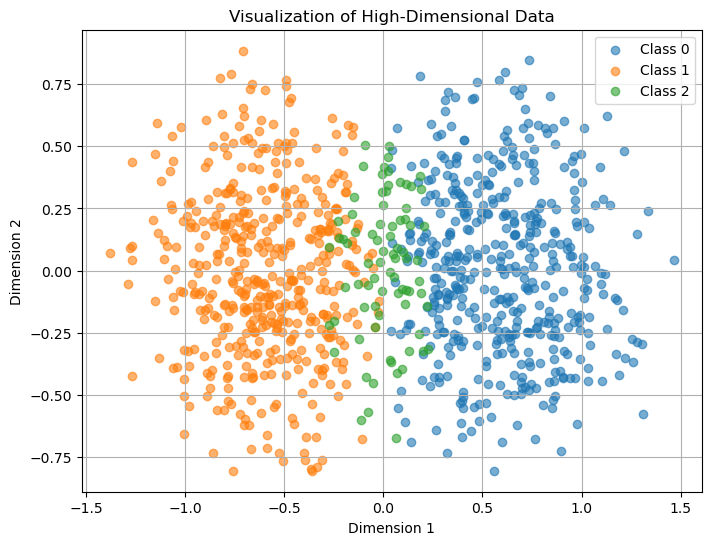

In [7]:
# 示例：生成每类 500 个样本的高维数据
num_samples = 500
dimensions = 8
radius_0 = 1.0
radius_1 = 1.0
center_0 = [0.6] * dimensions  # 类别 0 的球心位置
center_1 = [1.0] * dimensions  # 类别 1 的球心位置

# 生成数据
features, labels = generate_sphere_data_with_overlap(
    num_samples, dimensions, radius_0, radius_1, center_0, center_1
)

# 使用可视化
visualize_2d(features, labels)

# 数据转换
将数据集转化为 TensorDataset，方便接下来的训练

In [52]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# 找到标签为 2 的索引
idx_2 = (labels == 2)
num_idx_2 = idx_2.sum().item()
# 随机生成 0 或 1 的替换标签
random_labels = torch.randint(0, 2, (num_idx_2,), dtype=torch.long)
# 替换标签
labels[idx_2] = random_labels

# 将 features 和 labels 转换为 TensorDataset
dataset = TensorDataset(features, labels)

# 使用 DataLoader 以便进行批量加载
batch_size = 64  # 设置每个 batch 的大小
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 检查 DataLoader 输出
for batch_features, batch_labels in train_loader:
    print("Batch features shape:", batch_features.shape)
    print("Batch labels shape:", batch_labels.shape)
    break


Batch features shape: torch.Size([64, 8])
Batch labels shape: torch.Size([64])


# 利用构造的数据集对FBM进行训练

In [53]:
from loss.loss import FBMLoss
from models.modelset import FBMLayer
import torch.optim as optim

# 定义超参数
hidden_dim =10
num_classes = 2      # MNIST有10个类别
learning_rate = 0.01
num_epochs = 20
batch_size = 64
alpha = 1.0
df = 0.02

# 实例化模型、定义损失函数和优化器
model = FBMLayer(dimensions, hidden_dim).to(device)
criterion = FBMLoss(hidden_dim, 0.01, df, alpha)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model.train()
# 训练模型
for epoch in range(num_epochs):
    for images, labels in train_loader:
        # 将图像和标签移动到 GPU 上
        images = images.view(-1, dimensions).to(device)  # 展平图像并转移到 GPU
        labels = labels.to(device)  # 标签移动到 GPU
        #labels_one_hot = F.one_hot(labels, num_classes=num_classes).float()
        
        # 前向传播
        outputs = model(images)
        #loss = criterion(outputs, labels_one_hot, model.linear.weight)
        loss = criterion(outputs, labels, model.linear.weight)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/20], Loss: 0.0105
Epoch [2/20], Loss: 0.0086
Epoch [3/20], Loss: 0.0095
Epoch [4/20], Loss: 0.0085
Epoch [5/20], Loss: 0.0093
Epoch [6/20], Loss: 0.0089


Epoch [7/20], Loss: 0.0103
Epoch [8/20], Loss: 0.0083
Epoch [9/20], Loss: 0.0090
Epoch [10/20], Loss: 0.0087
Epoch [11/20], Loss: 0.0093
Epoch [12/20], Loss: 0.0097
Epoch [13/20], Loss: 0.0089
Epoch [14/20], Loss: 0.0093
Epoch [15/20], Loss: 0.0096
Epoch [16/20], Loss: 0.0082
Epoch [17/20], Loss: 0.0085
Epoch [18/20], Loss: 0.0092
Epoch [19/20], Loss: 0.0093
Epoch [20/20], Loss: 0.0095


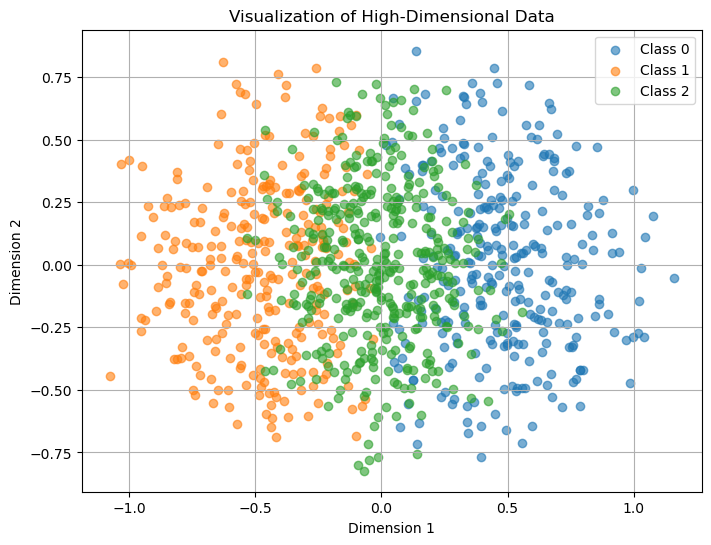

In [54]:
# 示例：生成每类 500 个样本的高维数据
num_samples = 500

# 生成数据
features, labels = generate_sphere_data_with_overlap(
    num_samples, dimensions, radius_0, radius_1, center_0, center_1
)


# 使用可视化
visualize_2d(features, labels)

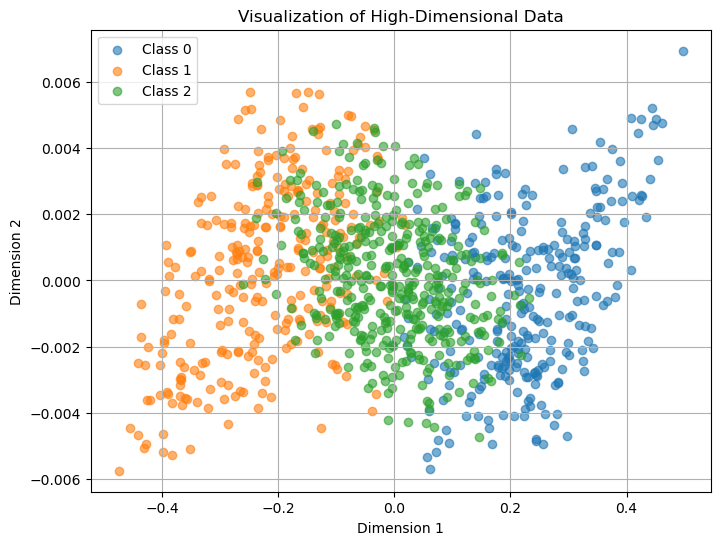

In [55]:
visualize_2d(model(features.to(device)).cpu(), labels)